# GNNs for Graph Classification

Example of using GNNs for graph classification.


In [1]:
import numpy as np
import networkx as nx
import torch

import dgl
from dgl.data import TUDataset
from dgl.data.utils import split_dataset
from dgl.dataloading.pytorch import GraphDataLoader
from dgl.nn import GraphConv, SumPooling, AvgPooling, MaxPooling, GlobalAttentionPooling

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Using backend: pytorch


## Data

We are going to use the `ENZYMES` dataset. There are 600 graphs in this dataset and each graph corresponds to a molecule. Our goal is to train a model to predict one of 6 properties for each molecule.

In [2]:
dataset = TUDataset(name='enzymes')

The dataset comprises of 600 graphs

In [3]:
len(dataset)

600

Let's have a look at the first graph

In [4]:
dataset[0]

(Graph(num_nodes=37, num_edges=168,
       ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'node_attr': Scheme(shape=(18,), dtype=torch.float64), 'node_labels': Scheme(shape=(1,), dtype=torch.int64)}
       edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}),
 tensor([5]))

Each element of `dataset` is a 2-tuple where the first element is the graph object and the second the graph's label.

In [5]:
dataset[0][0]

Graph(num_nodes=37, num_edges=168,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'node_attr': Scheme(shape=(18,), dtype=torch.float64), 'node_labels': Scheme(shape=(1,), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})

Let's visualize the first graph. We are going to use `NetworkX` for graph drawing.

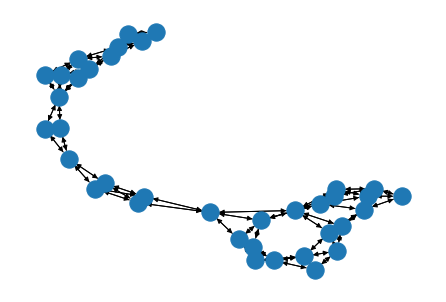

In [6]:
graph_nx = dgl.to_networkx(dataset[0][0])
nx.draw(graph_nx)

The nodes in the graph have 18-dimensional feature vectors.

In [7]:
dataset[0][0].ndata["node_attr"].shape

torch.Size([37, 18])

The graph labels are integers in the range \[0,5\]

In [8]:
dataset[0][1]

tensor([5])

We are going to add self loops to all nodes.

In [9]:
dataset = [
        (dgl.add_self_loop(dgl.remove_self_loop(el[0])), el[1]) for el in dataset
    ]

Let's split our data into train, validation, and test sets.

In [10]:
train_data, val_data, test_data = split_dataset(dataset, 
                                                frac_list=[0.8, 0.1, 0.1], 
                                                shuffle=True, 
                                                random_state=42)

For model training and evaluation, we need to create data loaders. We do this next.

In [11]:
train_data_loader = GraphDataLoader(train_data, batch_size=32, shuffle=True, drop_last=False, num_workers=0)
val_data_loader = GraphDataLoader(val_data, batch_size=32, shuffle=True, drop_last=False, num_workers=0)
test_data_loader = GraphDataLoader(test_data, batch_size=32, shuffle=True, drop_last=False, num_workers=0)

## The GNN Model

The model we are considering will consist of 2 GCN layers followed by a pooling layer.

In [12]:
class GNN(torch.nn.Module):
    def __init__(self, in_feats, hidden_feats, num_classes, activation, pooling="mean"):
        super(GNN, self).__init__()
        self.gcn_1 = GraphConv(in_feats, hidden_feats)
        self.gcn_2 = GraphConv(hidden_feats, num_classes)
        
        self.pool = None
        if pooling == "mean":
            self.pool = AvgPooling()
        elif pooling == "sum":
            self.pool = SumPooling()
        elif pooling == "max":
            self.pool = MaxPooling()
        elif pooling == "attention":            
            self.pool = GlobalAttentionPooling(torch.nn.Linear(num_classes, 1))
        else:
            raise Exception(f"pooling should be one of mean, sum, max, attention but found {pooling}")
            
        self.activation = activation()
    
    def forward(self, graph, features):
        h = self.gcn_1(graph, features)
        h = self.activation(h)
        h = self.gcn_2(graph, h)
        h = self.pool(graph, h)
        
        return h
    
    def reset_parameters(self):
        self.gcn_1.reset_parameters()
        self.gcn_2.reset_parameters()

In [13]:
model = GNN(in_feats=18, hidden_feats=16, num_classes=6, activation=torch.nn.ReLU, pooling="max")

Setup the optimiser.

In [14]:
optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

Lastly, we need to specify what loss to use. Since we are solving a multi-class classification problem, we are going to optimise the cross-entropy loss.

In [15]:
criterion = torch.nn.CrossEntropyLoss()

Let us create two helper methods, one for training our model and one for calculating the metrics.

In [16]:
def train(model, optimiser, criterion, train_data_loader, val_data_loader, test_data_loader, epochs=100):
    
    losses_and_metrics = { "train_loss": [], "train_acc": [],
                           "val_loss": [], "val_acc": [],
                           "test_loss": [], "test_acc": [] }
    
    for epoch in range(epochs):
        model.train()
        for graphs, labels in train_data_loader:  # one batch of graphs
            optimiser.zero_grad()

            node_features = graphs.ndata["node_attr"].float()
            pred = model(graphs, node_features)
            
            loss = criterion(pred, labels.long().squeeze(-1))
            loss.backward()
            optimiser.step()
        # evaluate the model on the three datasets
        for eval_data_loader, dataset_name in zip([train_data_loader, val_data_loader, test_data_loader], ["train", "val", "test"]):
            acc, loss =predict(model, criterion, eval_data_loader)        
            losses_and_metrics[f"{dataset_name}_loss"].append(loss)
            losses_and_metrics[f"{dataset_name}_acc"].append(acc)
            
    return losses_and_metrics

In [17]:
def predict(model, criterion, data_loader):
    model.eval()
    y_hat = []
    y = []
    loss = 0
    num_graphs = 0
    for graphs, labels in data_loader:
        node_features = graphs.ndata["node_attr"].float()
        labels = labels.squeeze(-1)
        pred = model(graphs, node_features)
        loss += criterion(pred, labels).item()*len(labels)
        num_graphs += len(labels)

        y_hat.extend(pred.argmax(1))
        y.extend(labels)
            
    return accuracy_score(y, y_hat), loss / num_graphs

In [18]:
model.reset_parameters()
losses_and_metrics = train(model, optimiser, criterion, train_data_loader, val_data_loader, test_data_loader, epochs=150)

Let's plot the losses.

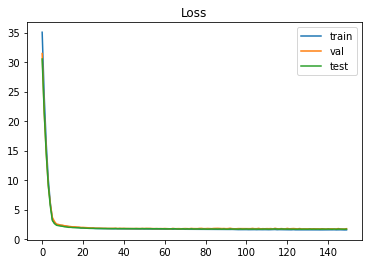

In [19]:
plt.plot(losses_and_metrics["train_loss"], label="train")
plt.plot(losses_and_metrics["val_loss"], label="val")
plt.plot(losses_and_metrics["test_loss"], label="test")
plt.title('Loss')
plt.legend();

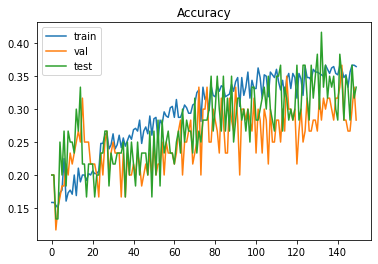

In [20]:
plt.plot(losses_and_metrics["train_acc"], label="train")
plt.plot(losses_and_metrics["val_acc"], label="val")
plt.plot(losses_and_metrics["test_acc"], label="test")
plt.title('Accuracy')
plt.legend();

## Jumping Knowledge Network

We are going to extend our graph classification GNN with jump connections.

In [21]:
class JKNet(torch.nn.Module):
    def __init__(self, in_feats, hidden_feats, num_classes, activation, pooling="mean"):
        super(JKNet, self).__init__()
        self.gcn_1 = GraphConv(in_feats, hidden_feats)
        self.gcn_2 = GraphConv(hidden_feats, hidden_feats)
        self.linear = torch.nn.Linear(hidden_feats*2, num_classes)
        
        self.pool = None
        if pooling == "mean":
            self.pool = AvgPooling()
        elif pooling == "sum":
            self.pool = SumPooling()
        elif pooling == "max":
            self.pool = MaxPooling()
        elif pooling == "attention":
            self.pool = GlobalAttentionPooling(torch.nn.Linear(hidden_feats, 1))
        else:
            raise Exception(f"pooling should be one of mean, sum, max, attention but found {pooling}")
            
        self.activation = activation()
    
    def forward(self, graph, features):
        h = self.activation(self.gcn_1(graph, features))
        h_1 = self.pool(graph, h)
        h = self.activation(self.gcn_2(graph, h))
        h_2 = self.pool(graph, h)
        h = torch.cat([h_1, h_2], dim=1)
        h = self.linear(h)
        
        return h
    
    def reset_parameters(self):
        self.gcn_1.reset_parameters()
        self.gcn_2.reset_parameters()
        self.linear.reset_parameters()

In [22]:
model_jknet = JKNet(in_feats=18, hidden_feats=16, num_classes=6, activation=torch.nn.ReLU, pooling="max")
optimiser = torch.optim.Adam(model_jknet.parameters(), lr=0.001, weight_decay=0.0001)

In [23]:
model_jknet.reset_parameters()
losses_and_metrics = train(model_jknet, optimiser, criterion, train_data_loader, val_data_loader, test_data_loader, epochs=150)

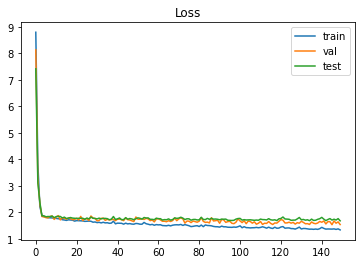

In [24]:
plt.plot(losses_and_metrics["train_loss"], label="train")
plt.plot(losses_and_metrics["val_loss"], label="val")
plt.plot(losses_and_metrics["test_loss"], label="test")
plt.title('Loss')
plt.legend();

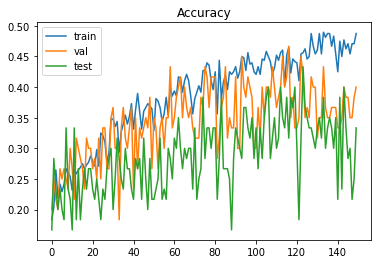

In [25]:
plt.plot(losses_and_metrics["train_acc"], label="train")
plt.plot(losses_and_metrics["val_acc"], label="val")
plt.plot(losses_and_metrics["test_acc"], label="test")
plt.title('Accuracy')
plt.legend();

## Exercises

1. Can you improve the results? What if you use a deeper or wider or both GNN?
2. Replace GCNConv with GATConv. Does it improve performance?
3. For JKNet, conder concatenating the node features before graph pooling. Does it make a difference?